In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from config import getClient
from rpy2.robjects import r, pandas2ri

In [2]:
dataloc = getClient("MC")

In [9]:
df = pd.read_csv(dataloc+"UAEseries.csv")

train = df.head(-12)
test = df.tail(12)

# Check that both record counts and dollar values got split correctly
assert (train.shape[0] + test.shape[0] == df.shape[0])
assert (train["Amount"].sum() + test["Amount"].sum() == df["Amount"].sum())

In [4]:
series = train["Amount"]

In [23]:
def decompose(series, frequency, s_window = 'periodic', log = False,  **kwargs):
    '''
    Decompose a time series into seasonal, trend and irregular components using loess, 
    acronym STL.
    https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl

    params:
        series: a time series

        frequency: the number of observations per “cycle” 
                   (normally a year, but sometimes a week, a day or an hour)
                   https://robjhyndman.com/hyndsight/seasonal-periods/

        s_window: either the character string "periodic" or the span 
                 (in lags) of the loess window for seasonal extraction, 
                 which should be odd and at least 7, according to Cleveland 
                 et al.

        log:    boolean.  take log of series



        **kwargs:  See other params for stl at 
           https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl
    '''

    df = pd.DataFrame()
    df['date'] = series.index
    if log: series = series.pipe(np.log)
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df, decomposed


In [10]:
train = train.set_index("Month")
tom = train["Amount"]

In [24]:
ts, decomposed = decompose(tom, frequency=12)

In [17]:
ts.to_csv(dataloc+"stlResults.csv")

In [18]:
ts.columns

Index(['date', 'observed', 'trend', 'seasonal', 'residuals'], dtype='object')

In [19]:
dt       = ts["date"]
actual   = ts["observed"]
trend    = ts["trend"]
seasonal = ts["seasonal"]
resid    = ts["residuals"]

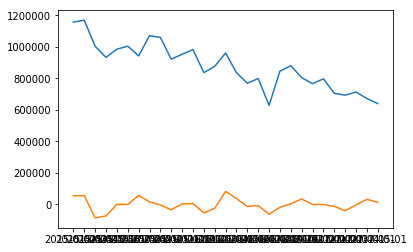

In [22]:
plt.plot(dt, actual)
plt.plot(dt, resid)
plt.show()

In [33]:
tom.shape

(29,)

In [35]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
tom = np.array(tom)
fit = r.stl(tom, t_window=12, frequency=12,s_window="periodic", robust=True)

/home/tbrownex/tensorflow/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in (function (x, s.window, s.degree = 0, t.window = NULL, t.degree = 1,  : 
  unused argument (frequency = 12)

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in (function (x, s.window, s.degree = 0, t.window = NULL, t.degree = 1,  : 
  unused argument (frequency = 12)


In [ ]:
eeadj <- seasadj(fit)